#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Ресемплирование-данных" data-toc-modified-id="Ресемплирование-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ресемплирование данных</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Подготовка-к-обучению" data-toc-modified-id="Подготовка-к-обучению-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка к обучению</a></span></li><li><span><a href="#Создание-и-обучение-моделей" data-toc-modified-id="Создание-и-обучение-моделей-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Создание и обучение моделей</a></span></li></ul></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование моделей</a></span></li><li><span><a href="#Итоги-исследования" data-toc-modified-id="Итоги-исследования-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоги исследования</a></span></li></ul></div>

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Цель исследования - построить модель для такого предсказания. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48. Для исследования предоставлены данные об осуществленных заказах такси за определенный период.

## Подготовка данных

In [1]:
# Импортируем необходимые для работы библиотеки.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')

Откроем csv-файл с таблицей и сохраним в переменную "df".

In [2]:
# При открытии файла используем конструкцию try-except. 

try:
    df = pd.read_csv('/datasets/taxi.csv')

except:
    try:
        df = pd.read_csv('datasets/taxi.csv')

    except:
        print('Проверьте путь к файлу.')

### Изучение данных

In [3]:
# Просматриваем первые строки датафрейма.

df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
# Общая информация о датафрейме

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# Статистические характеристики датафрейма

df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
print(f'Доля нулей в столбце "num_orders": '
      f'{df.loc[df["num_orders"] == 0, "num_orders"].count() / df.shape[0]:.1%}')

Доля нулей в столбце "num_orders": 2.0%


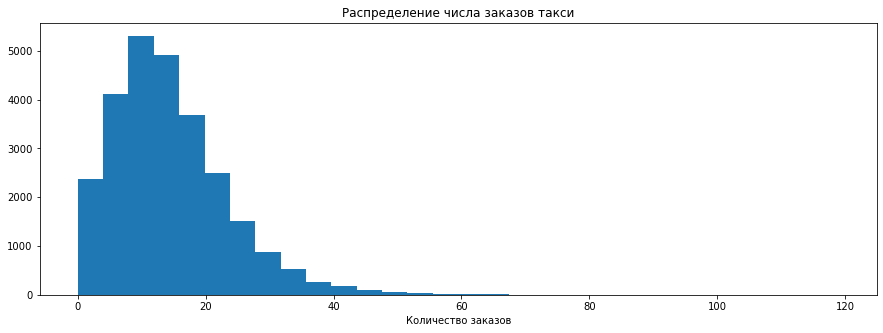

In [7]:
# Распределение числа заказов

plt.figure(figsize=(15, 5))
plt.hist(df['num_orders'], bins=30)
plt.title("Распределение числа заказов такси")
plt.xlabel("Количество заказов")
plt.show()

In [8]:
# Проверяем датафрейм на наличие дубликатов.

print('Количество дубликатов в таблице:', df.duplicated().sum())

Количество дубликатов в таблице: 0


In [9]:
# Выясняем диапазон дат.

print(f"Данные предоставлены за период с {df['datetime'].min()} по {df['datetime'].max()}.")

Данные предоставлены за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00.


__Выводы:__

1. Предоставленная таблица представляет собой датасет с временными рядами. В ней 26496 строк и 2 столбца.
 
 
2. В столбце 'datetime' содержатся даты, тип данных - object. В столбце 'num_orders' - количества заказов такси, тип - int64.


3. Пропущенных значений в таблице нет.


4. Аномалий в статистиках нет: среднее, медиана, стандартное отклонение, минимум и максимум в пределах нормы. Количество нулевых значений составляет 2%.


5. Целевой признак (количество заказов) имеет распределение Пуассона, приближающееся к нормальному.


6. Дубликатов стреди строк не обнаружено.


7. Данные в таблице предоставлены за период с 1 марта по 31 августа 2018 года. Временной интервал составляет 10 минут.

### Ресемплирование данных

Произведем ресемплирование данных по одному часу. Но сперва подготовим индексы.

In [10]:
# Изменяем тип данных столбца 'datetime' с object на datetime64.
# Снова просматриваем общую информацию о датафрейме.

df['datetime'] = pd.to_datetime(df['datetime'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


In [11]:
# Устанавливаем индекс таблицы равным столбцу 'datetime', сортируем индексы.
# Просматриваем обновленный датафрейм (данные за первый час).
# Вычисляем сумму заказов за первый час.

df = df.set_index('datetime').sort_index()
display(df.head(6))
print(df.head(6).sum())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21


num_orders    124
dtype: int64


In [12]:
# Проверяем, в хронологическом ли порядке расположены данные.

print('Данные расположены в хронологическом порядке:', df.index.is_monotonic)

Данные расположены в хронологическом порядке: True


In [13]:
# Ресемплируем данные: изменяем интервал со значениями ряда с 10 минут на 1 час.

df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


__Итоги:__

1. Тип данных в столбце с датой и временем изменен на datetime.


2. Столбец с датой и временем преобразован в столбец с индексами, с сортировкой датафрейма по индексам.


3. Расположение временных рядов проверено на монотонность.


4. Данные ресемплированы. Интервал со значениями ряда изменен с 10 минут на 1 час.


## Анализ данных

Разложим временной ряд на три составляющие: тренд, сезонность и остаток.

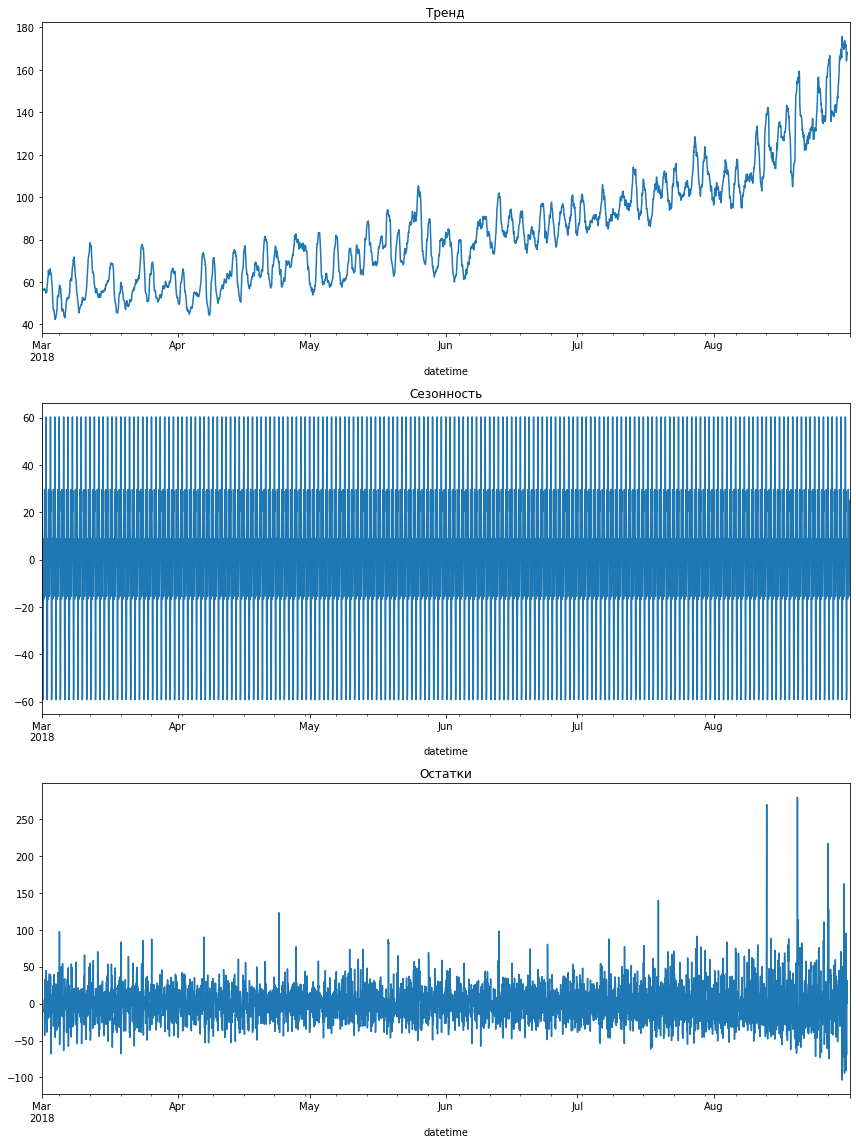

In [14]:
# Проводим декомпозицию всего датасета.
# Выводим графики, демонстрирующие тренд, сезонность и остатки.

decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 16))

plt.subplot(311)
decomposed.trend.plot()
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot()
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot()
plt.title('Остатки')

plt.tight_layout()

В течение всего периода наблюдается положительный тренд, который означает общий рост числа клиентов сервиса. Однако прослеживается также четкая сезонность, период которой, видимо, составляет сутки. Проверим это, увеличив масштаб.

In [15]:
# Просматриваем последние строки датафрейма (данные за последние 7 дней).

df.tail(24*7)

,num_orders
datetime,
2018-08-25 00:00:00,273
2018-08-25 01:00:00,246
2018-08-25 02:00:00,160
2018-08-25 03:00:00,187
2018-08-25 04:00:00,196
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [16]:
# Вычисляем последний день недели.

df.index[-1].day_name()

'Friday'

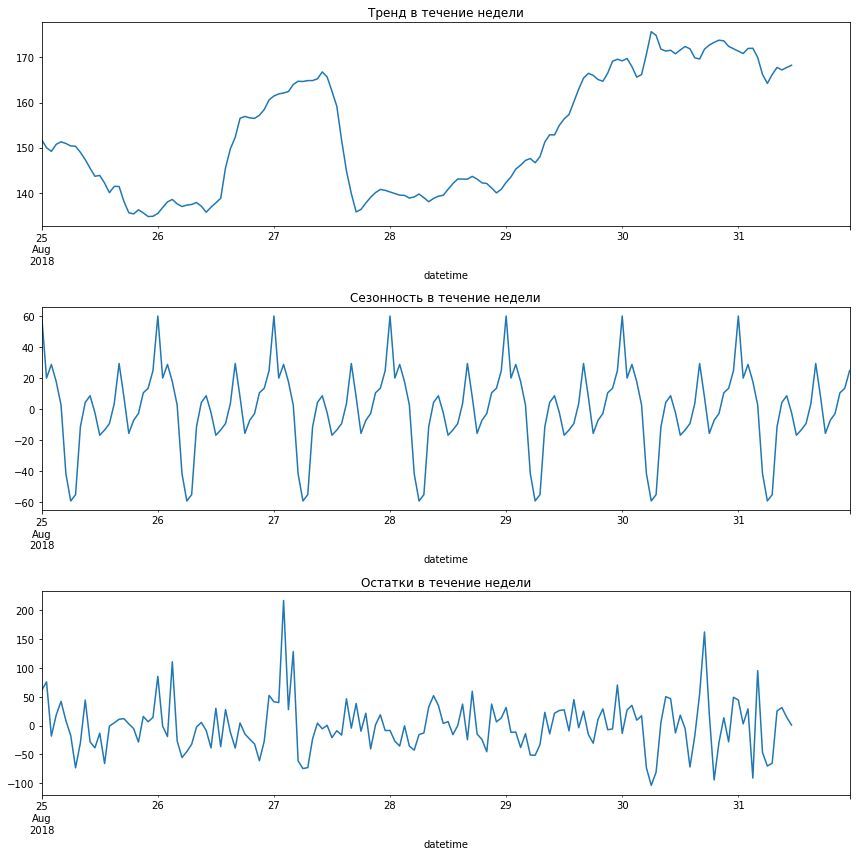

In [17]:
# Выводим графики тренда, сезонности и остатков за последнюю неделю периода.

plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend['2018-08-25':'2018-08-31'].plot()
plt.title('Тренд в течение недели')

plt.subplot(312)
decomposed.seasonal['2018-08-25':'2018-08-31'].plot()
plt.title('Сезонность в течение недели')

plt.subplot(313)
decomposed.resid['2018-08-25':'2018-08-31'].plot()
plt.title('Остатки в течение недели')

plt.tight_layout()

__Выводы:__

1. В течение всего периода в изменении числа заказов такси наблюдается положительный тренд. Он немного усиливается во второй половине августа, что, вероятно, связано с возвращением людей с отпусков и подготовкой к новому учебному году.

 
2. По данным последней недели можно сделать вывод, что меньше всего заказов поступает на выходных, особенно - в воскресенье. Пики наблюдаются в понедельник, а также - в четверг и пятницу, т.е. в начале и ближе к концу рабочей недели. 


3. Более четкая сезонность проявляется в течение дня: утром - спад; всплески ближе к полудню, в вечерние часы пик, а также в районе полуночи.

## Обучение моделей

### Подготовка к обучению

Создадим функцию для добавления новых признаков: 
- календарные признаки (месяц, день, день недели, час);
- отстающие значения;
- скользящее среднее.

In [18]:
# Создаем функцию для добавления новых признаков.

def make_features(data, max_lag, rolling_mean_size):
    new_df = data.copy()
    columns = ['month', 'day', 'dayofweek', 'hour']
    cal_features = [new_df.index.month, 
                    new_df.index.day, 
                    new_df.index.dayofweek, 
                    new_df.index.hour]
    for i in range(4):
        new_df[columns[i]] = cal_features[i]
        
    for lag in range(1, max_lag + 1):
        new_df['lag_{}'.format(lag)] = new_df['num_orders'].shift(lag)

    new_df['rolling_mean'] = new_df['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    
    return new_df

In [19]:
# Применяем функцию, подобрав оптимальные количество лагов и размер окна скользящего среднего.
# Просматриваем первые строки обновленного датафрейма.

df = make_features(df, 4, 3)
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,93.333333
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,74.000000


In [20]:
# Разбиваем датасет на тренировочную и тестовую выборки в соотношении 9:1.
# Удаляем пропуски в тренировочной выборке.

train, test = train_test_split(df, test_size=0.1, shuffle=False)

train = train.dropna()

In [21]:
# Выводим данные о размерах выборок.
# Проверяем начало и конец каждой выборки.
# Выводим общую информацию о тренировочной выборке.

print(train.shape)
print(test.shape)
print()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())
print()

train.info()

(3970, 10)
(442, 10)

2018-03-01 04:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3970 entries, 2018-03-01 04:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3970 non-null   int64  
 1   month         3970 non-null   int64  
 2   day           3970 non-null   int64  
 3   dayofweek     3970 non-null   int64  
 4   hour          3970 non-null   int64  
 5   lag_1         3970 non-null   float64
 6   lag_2         3970 non-null   float64
 7   lag_3         3970 non-null   float64
 8   lag_4         3970 non-null   float64
 9   rolling_mean  3970 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 341.2 KB


In [22]:
# Выделяем в каждой выборке признаки и целевой признак (количество заказов).

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [23]:
# Создаем функцию для расчета метрики RMSE.

def rmse(target, predictions):
    rmse = mean_squared_error(target, predictions, squared=False)
    return rmse

In [24]:
# Создаем параметры scoring и cv для обучения моделей.

scorer = make_scorer(rmse, greater_is_better=False)

tscv = TimeSeriesSplit()

__Итоги:__

1. Создана функция make_features() для добавления новых признаков в датасет. Добавлены календарные признаки (месяц, день, день недели, час), отстающие значения (4 столбца), скользящее среднее (с размером окна 3).


2. Датасет разбит на тренировочную и тестовую выборки в соотношении 9:1. Удалены пропуски в тренировочной выборке.


3. Из каждой выборки выделяены признаки и целевой признак (количество заказов).


4. Создана функция для расчета метрики RMSE и параметр scorer для обучения моделей.


### Создание и обучение моделей

Проверим 4 структуры машинного обучения: 
- LinearRegression;
- RandomForestRegressor;
- LGBMRegressor;
- CatBoostRegressor.

Подберем оптимальные гиперпараметры для каждой из них.

In [25]:
# LinearRegression

model = LinearRegression()

parameters = {'normalize':[True, False],
              'fit_intercept':[True, False]}

grid = RandomizedSearchCV(model, parameters, cv=tscv, scoring=scorer, n_jobs=-1, random_state=12345)
grid.fit(features_train, target_train)

print('Наилучшие параметры для LinearRegression:', grid.best_params_)
print('RMSE для LinearRegression составляет', -grid.best_score_)
print()

Наилучшие параметры для LinearRegression: {'normalize': True, 'fit_intercept': False}
RMSE для LinearRegression составляет 31.42504585070926



In [26]:
# RandomForestRegressor
# Время на обработку - около 30 сек

model = RandomForestRegressor(random_state=12345)
    
parameters = {'n_estimators': range(50, 151, 10), 
              'max_depth': range(5, 15)}

grid = RandomizedSearchCV(model, parameters, cv=tscv, scoring=scorer, random_state=12345)
grid.fit(features_train, target_train)

print('Наилучшие параметры для RandomForestRegressor:', grid.best_params_)
print('RMSE для RandomForestRegressor составляет', -grid.best_score_)
print()

Наилучшие параметры для RandomForestRegressor: {'n_estimators': 140, 'max_depth': 13}
RMSE для RandomForestRegressor составляет 25.5650069756944



In [27]:
# LGBMRegressor

model = LGBMRegressor(random_state=12345)
    
parameters = {'n_estimators': range(50, 151, 10),
              'num_leaves': [20, 30, 40],
              'learning_rate':[0.01, 0.02, 0.04]}

grid = RandomizedSearchCV(model, parameters, cv=tscv, scoring=scorer, random_state=12345)
grid.fit(features_train, target_train)

print('Наилучшие параметры для LGBMRegressor:', grid.best_params_)
print('RMSE для LGBMRegressor составляет', -grid.best_score_)
print()

Наилучшие параметры для LGBMRegressor: {'num_leaves': 30, 'n_estimators': 110, 'learning_rate': 0.04}
RMSE для LGBMRegressor составляет 25.489233926664667



In [28]:
# CatBoostRegressor
# Время на обработку - около 30 сек

model = CatBoostRegressor(random_state=12345)

parameters = {'learning_rate': [0.1, 0.3],
              'iterations': [100, 150, 300],
              'depth': [4, 5, 6]}

grid = RandomizedSearchCV(model, parameters, cv=tscv, scoring=scorer, random_state=12345)

grid.fit(features_train, target_train)

print('Наилучшие параметры для CatBoostRegressor:', grid.best_params_)
print('RMSE для CatBoostRegressor составляет', -grid.best_score_)
print()

0:	learn: 25.8563825	total: 158ms	remaining: 47.2s
1:	learn: 22.8433775	total: 163ms	remaining: 24.3s
2:	learn: 21.4528752	total: 168ms	remaining: 16.6s
3:	learn: 20.7708212	total: 172ms	remaining: 12.7s
4:	learn: 19.5758491	total: 176ms	remaining: 10.4s
5:	learn: 18.8795581	total: 181ms	remaining: 8.85s
6:	learn: 18.4109447	total: 185ms	remaining: 7.75s
7:	learn: 18.1187824	total: 189ms	remaining: 6.9s
8:	learn: 17.7712000	total: 194ms	remaining: 6.26s
9:	learn: 17.6159099	total: 199ms	remaining: 5.77s
10:	learn: 17.3968808	total: 204ms	remaining: 5.37s
11:	learn: 17.2443690	total: 208ms	remaining: 4.99s
12:	learn: 16.9846658	total: 211ms	remaining: 4.66s
13:	learn: 16.8289998	total: 213ms	remaining: 4.36s
14:	learn: 16.6970135	total: 216ms	remaining: 4.1s
15:	learn: 16.5124601	total: 218ms	remaining: 3.87s
16:	learn: 16.3516804	total: 220ms	remaining: 3.66s
17:	learn: 16.1438833	total: 222ms	remaining: 3.48s
18:	learn: 15.9368129	total: 224ms	remaining: 3.31s
19:	learn: 15.8514678	to

__Выводы:__

Модели с наиболее оптимальными параметрами продемонстрировали следующие результаты (время на подбор гиперпараметров и значение метрики RMSE):

1. Линейная регрессия : время - 0.147 с; RMSE - 31.42.


2. Регрессор случайного леса: время - 31.5 с; RMSE - 25.57.


3. Регрессор Light GBM: время - 45.8 с; RMSE - 25.49.


4. Регрессор CatBoost: время - 30.5 с; RMSE - 25.46.


Наилучший показатель качества предсказания - у модели CatBoostRegressor. Меньше всего времени на обработку ушло у линейной регрессии. Для окончательного выбора модели необходимо сравнить метрики на тестовой выборке.

## Тестирование моделей

Обучим модели вышеуказанных структур с подобранными параметрами. Составим сравнительные графики предсказаний и целевых значений в тестовой выборке. Вычислим значения RMSE.

In [29]:
# LinearRegression

model = LinearRegression(normalize=True, fit_intercept=False)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

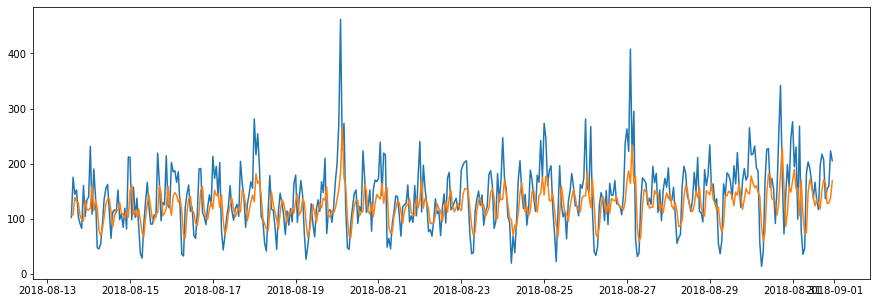

RMSE для LinearRegression составляет 52.13412889082336


In [30]:
plt.figure(figsize=(15, 5))
plt.plot(target_test.index, target_test, target_test.index, predictions)
plt.show()
print('RMSE для LinearRegression составляет', rmse(target_test, predictions))

In [31]:
# RandomForestRegressor

model = RandomForestRegressor(n_estimators=140, max_depth=13, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

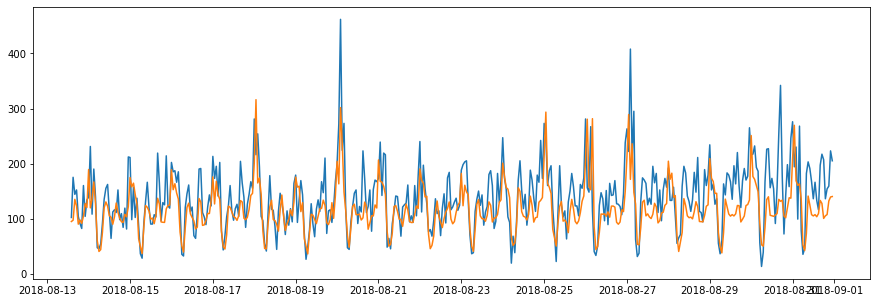

RMSE для RandomForestRegressor составляет 47.66362636940597


In [32]:
plt.figure(figsize=(15, 5))
plt.plot(target_test.index, target_test, target_test.index, predictions)
plt.show()
print('RMSE для RandomForestRegressor составляет', rmse(target_test, predictions))

In [33]:
# LGBMRegressor

model = LGBMRegressor(num_leaves=30, n_estimators=110, learning_rate=0.04, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

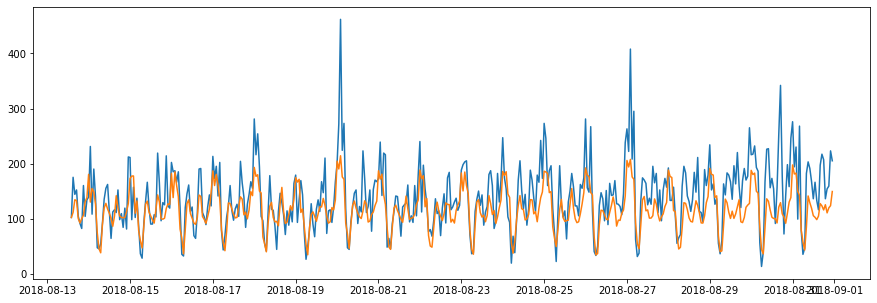

RMSE для LGBMRegressor составляет 46.08026270986048


In [34]:
plt.figure(figsize=(15, 5))
plt.plot(target_test.index, target_test, target_test.index, predictions)
plt.show()
print('RMSE для LGBMRegressor составляет', rmse(target_test, predictions))

In [35]:
# CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, iterations=300, depth=5, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

0:	learn: 36.8705451	total: 8.12ms	remaining: 2.43s
1:	learn: 35.4707277	total: 16.1ms	remaining: 2.4s
2:	learn: 34.2194945	total: 21.5ms	remaining: 2.13s
3:	learn: 33.3080771	total: 25.2ms	remaining: 1.87s
4:	learn: 32.2828743	total: 28.7ms	remaining: 1.69s
5:	learn: 31.3085777	total: 31.3ms	remaining: 1.53s
6:	learn: 30.5160610	total: 34ms	remaining: 1.42s
7:	learn: 29.7809641	total: 36.2ms	remaining: 1.32s
8:	learn: 29.2721914	total: 38.5ms	remaining: 1.24s
9:	learn: 28.8394839	total: 40.6ms	remaining: 1.18s
10:	learn: 28.4722797	total: 42.6ms	remaining: 1.12s
11:	learn: 28.1185854	total: 44.6ms	remaining: 1.07s
12:	learn: 27.6985571	total: 46.9ms	remaining: 1.03s
13:	learn: 27.3421083	total: 49.1ms	remaining: 1s
14:	learn: 27.0392674	total: 51.1ms	remaining: 971ms
15:	learn: 26.7488221	total: 53ms	remaining: 941ms
16:	learn: 26.5826433	total: 54.8ms	remaining: 913ms
17:	learn: 26.2309563	total: 56.6ms	remaining: 888ms
18:	learn: 25.9515260	total: 58.5ms	remaining: 865ms
19:	learn: 

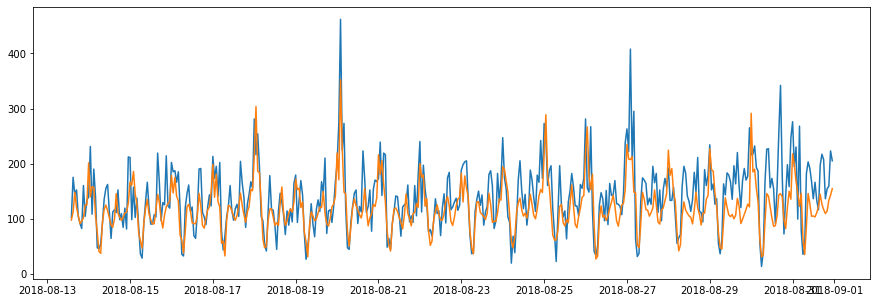

RMSE для CatBoostRegressor составляет 44.67937057780911


In [36]:
plt.figure(figsize=(15, 5))
plt.plot(target_test.index, target_test, target_test.index, predictions)
plt.show()
print('RMSE для CatBoostRegressor составляет', rmse(target_test, predictions))

Как видим, на тестовой выборке модель CatBoostRegressor также показала лучший результат.

Проверим модель на вменяемость, сравнив с фиктивной моделью.

In [37]:
# DummyRegressor

model = DummyRegressor()
model.fit(features_train, target_train)
predictions = model.predict(features_test)

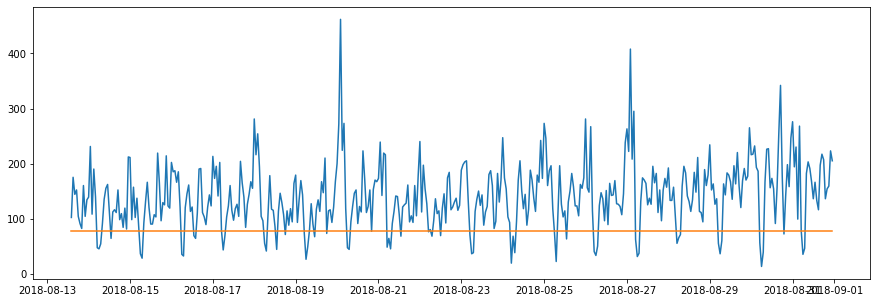

RMSE для DummyRegressor составляет 84.75012403274485


In [38]:
plt.figure(figsize=(15, 5))
plt.plot(target_test.index, target_test, target_test.index, predictions)
plt.show()
print('RMSE для DummyRegressor составляет', rmse(target_test, predictions))

Проверка на вменяемость пройдена.

__Выводы:__

Модели с подобранными параметрами продемонстрировали на тестовой выборке следующие значения метрики RMSE:

1. Линейная регрессия : 52.13.


2. Регрессор случайного леса: 47.66.


3. Регрессор Light GBM: 46.08.


4. Регрессор CatBoost: 44.68.


Хотя среднеквадратичная ошибка при проверке на тестовой выборке в 1,5-2 раза больше, чем на тренировочной, наилучший показатель качества предсказания по-прежнему у модели CatBoostRegressor. Проверку на вменяемость модель также прошла успешно.

## Итоги исследования 

1. __Задача исследования.__ Необходимо построить модель машинного обучения для сервиса такси, способную прогнозировать количество заказов на каждый следующий час, чтобы компания могла привлекать больше водителей в период пиковой нагрузки. При этом значение метрики RMSE на тестовой выборке должно быть не больше 48. Для исследования предоставлены исторические данные о заказах такси в аэропортах. 


2. __Изучение данных__. Таблица представляет собой датасет с временными рядами в 26496 строках и 2 столбцах и содержит данные за период с 1 марта по 31 августа 2018 года с временным интервалом 10 минут. В столбце 'datetime' содержатся даты, тип данных - object; в столбце 'num_orders' - количества заказов такси, тип - int64. Пропущенных значений в таблице нет. Дубликатов стреди строк не обнаружено. Статистики в пределах нормы. Количество нулевых значений составляет 2%. Целевой признак (количество заказов) имеет распределение Пуассона, приближающееся к нормальному.


3. __Обработка данных__. Тип данных в столбце с датой и временем изменен на datetime. Столбец с датой и временем преобразован в столбец с индексами, данные отсортированы по индексам. Расположение временных рядов проверено на монотонность. Данные ресемплированы: интервал со значениями ряда изменен с 10 минут на 1 час.


4. __Анализ данных__. В течение всего периода в изменении числа заказов такси наблюдается положительный тренд, немного усиливающийся во второй половине августа, что может быть связано с возвращением людей с отпусков и подготовкой к новому учебному году. По данным недельной сезонности, меньше всего заказов поступает в воскресенье, больше всего в понедельник, четверг и пятницу, т.е. в начале и ближе к концу рабочей недели. Четкая сезонность проявляется в течение дня: утром - спад; всплески ближе к полудню, в вечерние часы пик, а также в районе полуночи.


5. __Подготовка к обучению__. В таблицу добавлены 4 столбца со следующими календарными признаками: месяц, день, день недели, час; а также 4 столбца с отстающими значениями и столбец со скользящим средним (с размером окна 3). Датасет разбит на тренировочную и тестовую выборки в соотношении 9:1, в тренировочной выборке удалены пропуски. Из каждой выборки выделены признаки и целевой признак. Создана функция для расчета метрики RMSE и параметр scorer для обучения моделей.


6. __Обучение моделей__. Проверены четыре структуры машинного обучения: Линейная регрессия, Регрессор случайного леса, Регрессор Light GBM, а также Регрессор CatBoost. В результате среди моделей с наиболее оптимальными гиперпараметрами, подобранными с помощью RandomizedSearchCV, лучшей по времени, затрачиваемому на обучение и предсказание, оказалась модель LinearRegression (примерно 0.18 с). Однако по качеству прогноза лучший показатель продемонстрировала модель CatBoostRegressor (RMSE - 23.18). Учитывая, что подбор параметров у последней длился менее минуты, наиболее оптимальным вариантом для выбора можно считать именно ее.


7. __Тестирование моделей__. Модели с подобранными параметрами продемонстрировали на тестовой выборке следующие значения метрики RMSE: Линейная регрессия - 52.13; Регрессор случайного леса - 47.66; Регрессор Light GBM - 46.08; Регрессор CatBoost - 44.68. Метрика RMSE при проверке на тестовой выборке оказалась в 1,5-2 раза больше, чем на тренировочной, что, вероятнее всего, связано с переобученностью моделей, а также с уже упомянутым усиливающимся трендом, конец которого как раз пришелся на тестовую выборку. Тем не менее, значения RMSE у всех моделей, кроме LinearRegression, удовлетворяют требованиям исследования. Однако наилучший показатель качества предсказания по-прежнему у модели CatBoostRegressor, которая также успешно прошла проверку на вменяемость. Результат: лучшая модель - CatBoostRegressor, RMSE - 44.68.